### Basics of Compressed Sensing

%LaTeX <br>
Compressed Sensing is a method of using sub-Nyquist (in the sense of Shannon-Nyquist's theorem concerning minimum sampling frequency) sampling in order to reconstruct a signal with high accuracy. 
<br>
<br>
It can be divided into two applications depending on where you are starting: compression, if you already have a the full signal, and reconstruction if you do not have the full signal. <br>
<br>
The math of compressed sensing is about solving equations of the form: $A\vec{x} = \vec{b}$. <br>
Recall that there are three cases w/r/t $A\vec{x} = \vec{b}$: <br>
&ensp;&ensp;&ensp; The overdetermined case, where A has fewer columns than rows, and equations are linear combinations of others. <br>
&ensp;&ensp;&ensp; The unique case, where there exists only 1 solution. <br>
&ensp;&ensp;&ensp; The underdetermined case, where A has many more columns than rows, leading to an infinite number of solutions to $A\vec{x} = \vec{b}$
<br>
Compressed sensing is focussed on finding solutions to the underdetermined case. It is possible to find unique solutions when we assume that $\vec{x}$ is _sparse_ in some basis. I.e. if we can find a basis where $\vec{x}$ is sparse, then the underdetermined system of equations $A\vec{x} = \vec{b}$ can be solved _exactly_. 
<br>
<br>
Let $dim(\vec{b}) = M << N = dim(\vec{x})$ <br>
We assume $\vec{x} = \Phi \vec{s}$ where $\vec{s}$ has at most S non-zero values (called S-sparse) and $dim(\vec{s})=dim(\vec{x})$, and $\Phi$ is an inverse mapping from the space in which our signal is sparse to the original space with dimensions $NxN$, then we can write $\vec{b} = A\Phi \vec{s}$.
$A$ has shape $MxN$. The combined matrix $A\Phi$ is called the _sensing matrix_. 
<br>
Now to solve for our sparse signal we can perform the sparse regression: <br>
$$ argmin_\vec{w}(||\vec{b} - A\Phi\vec{w}||_2^2 + \lambda||\vec{w}||_1)$$ <br>
(There are other techniques that have been developed since ~2005 when the original compressed sensing papers were first published.) 
<br>
<br>
Before continuing we should be asking the question: "does any matrix A" work in $A\Phi$. To which the answer is not really. One of the first properties proved by Candes and Tao in the first papers was that $A$ must obey the Restricted Isometry Property (RIP). 

#### RIP

%LaTeX <br>
The Restricted Isometry Property is: <br>
$$ 1-\delta \le \frac{ ||\Phi\vec{x_1} - \Phi\vec{x_2}|| }{ || \vec{x_1} - \vec{x_2} || } \le 1+\delta, \;\;\; ||\vec{x_1}||_0,||\vec{x_2}||_0 \le S \in\mathbb{Z}$$ 
<br>
<br>
This just says that $\Phi$ preserves the $l_2$ distance between vectors that are at most S-sparse after transformation, to w/in some constant $\delta$ we hope is small. 
<br>
Imagine $\vec{x_1}$ is the perfect, sparse signal. Except our data has some noise $\vec{x_2} = \vec{x_1} + \vec{\epsilon}$, then since $||\vec{x_1} - \vec{x_2}||_2^2 = ||\epsilon||_2^2 \ge 0$ we want $||\Phi\vec{x_1} - \Phi\vec{x_2}||_2^2 $ to also be small. Otherwise very small measurement error would lead to very large reconstruction error. 
<br>
<br>
What matrices obey the RIP? There are three primary options:
<br>
&ensp;&ensp;&ensp; - Random matrix sampled i.i.d. from sub-Gaussian probability distribution.      <br>
&ensp;&ensp;&ensp; - Random Fourier submatrix. (i.e. make a square DFT matrix, pick rows @ random) <br>
&ensp;&ensp;&ensp; -'Fast Johnson-Lindenstrauss Transform': mulitply the columns of any RIP matrix by random $\pm1$ to get a JL embedding, giving you a matrix obeying the RIP 
<br>
<br>
A note on reconstructing the sparse signal: if our matrix satisfies the RIP, then $l_0$-minimization is equivalent to $l_1$-minimization. This is important because $l_0$-minimization would be the optimal minimization procedure to obtain the sparse signal -- the problem is that performing the minimization is (apparently) NP-hard. Hence it is lucky that with matrices satisfying RIP, that a convex optimization problem ($l_1$-minimization) is equivalent to the optimal minimization. Allowing us to use techniques such as LASSO or FISTA to perform the reconstruction.

In [41]:
DIR = "F:/data/101_ObjectCategories/"
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.fftpack import dct, idct
import skimage.io as skio
import skimage.transform 
import pywt
from sklearn.linear_model import Lasso
import os

In [2]:
def signal_(t,f1,f2,f3):
    # t : array
    y = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + np.sin(2*np.pi*f3*t)
    return y

In [3]:
t = np.linspace(0,100,num=1000)

In [4]:
y = signal_(t, 100,20,7)

Text(0.5,0,'time')

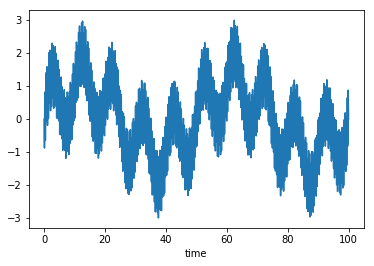

In [5]:
plt.plot(t,y)
plt.xlabel("time")

Shannon-Nyquist Theorem says to have a perfect reconstruction of our signal, we must sample at twice the highest frequency in the signal. In this example that would be at 200Hz. Assuming we don't even know the signal, how are we supposed to know at what frequency to sample at? <br>
This is where techniques from compressed sensing come into play. <br>

As long as we can assume that our signal is sparse in *some* basis, then we can find the sparse solution, and reconstruct our signal from there. In order to reconstruct our sparse vector, we must sample the signal randomly (in some sub-Gaussian method) through time. 

In [278]:
_frac = (1/8)
idxs = np.random.randint(low=0, high=1000,size=( int(_frac*1000) ) )
idxs = np.sort(idxs)

_sample = y[idxs]
print(_sample.shape)

(125,)


Text(0.5,1,'Signal with randomly sampled points using 12.5% of the signal')

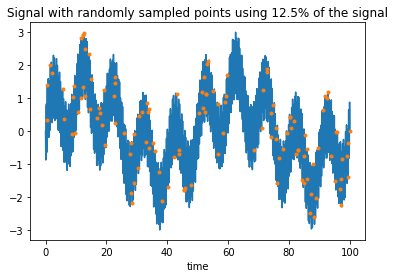

In [280]:
plt.plot(t,y)
plt.plot(t[idxs],_sample,linestyle="None",marker=".")
plt.xlabel("time")
plt.title("Signal with randomly sampled points using {}% of the signal".format(_frac * 100))

In [265]:
# Get space transform matrix.
D = dct(np.eye(1000))
A = D[idxs] # Take random rows

In [267]:
# Perform L1-minimization to obtain the sparse signal
reg = Lasso(alpha=0.1,max_iter=4000)
reg.fit(A, _sample)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=4000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Text(0.5,1,'Found signal')

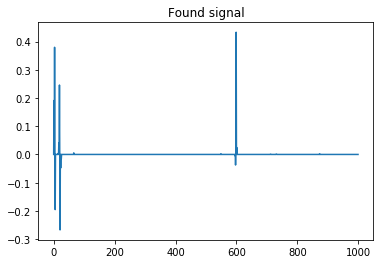

In [271]:
plt.plot(reg.coef_)
plt.title("Found signal")

Text(0.5,1,'Actual signal')

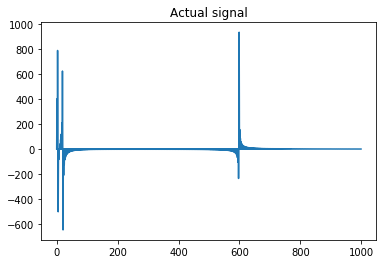

In [272]:
plt.plot( dct(y) )
plt.title("Actual signal")

The sparse signal we found is very similar looking to the actual sparse signal.

In [273]:
#_inv_dct = idct(reg.coef_)
_inv_dct = np.dot(D, reg.coef_) # Leave the space where we are sparse

Text(0.5,1,'The signal we found from reconstruction')

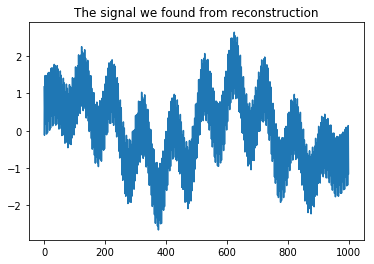

In [276]:
plt.plot(_inv_dct)
plt.title("The signal we found from reconstruction")

Text(0.5,1,'| reconstructed - actual |')

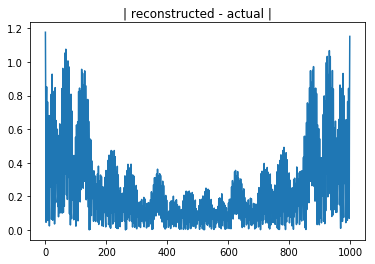

In [277]:
plt.plot( abs(_inv_dct - y) )
plt.title("| reconstructed - actual |")

We can see that at the limits our reconstruction was not very good. This is probably because we didn't sample very much around the boundaries.

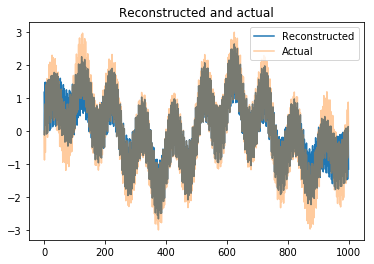

In [264]:
plt.plot(_inv_dct,    label="Reconstructed")
plt.plot(y,alpha=0.4, label="Actual")
plt.title("Reconstructed and actual")
plt.legend()

### Now with images

In [282]:
os.listdir(DIR)[0:20]

['accordion',
 'airplanes',
 'anchor',
 'ant',
 'BACKGROUND_Google',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair']

In [283]:
DIR_LOC = DIR+"bonsai/"
_img = skio.imread(DIR_LOC+"image_0001.jpg")

Most images are sparse in wavelet basis

In [284]:
_img.shape

(300, 280, 3)

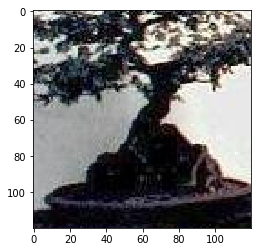

In [285]:
plt.imshow(_img[90:210,80:200,:])

In [287]:
_img1 = _img[90:210,80:200,0]
_img1Flat = _img1.flatten()
print(_img1Flat.shape)
print(_img1.shape)

(14400,)
(120, 120)


In [288]:
#rand_cA, rand_cD = pywt.idwt( np.eye(120*120),None ,wavelet="db1")
rand_cD = idct(np.eye(120*120))
#rand_cD = np.fft.ifft(np.eye(120*120))

In [289]:
rand_cD.shape

(14400, 14400)

In [338]:
numPixels = 6000 # CHANGE THIS TO TRY DIFFERENT PERCENTAGES OF TOTAL DATA

In [339]:
idxs = np.random.randint(low=0,high=_img1Flat.shape[0], size=numPixels)

In [340]:
# Take random pixels
_sample_img = _img1Flat[idxs]
_A_img      =   rand_cD[idxs]
print(_sample_img.shape,
     _A_img.shape)

(6000,) (6000, 14400)


In [341]:
# Take random linear combinations from the signal. Like having one pixel that takes combinations of light from a scene
# Google: one pixel camera
phi_rand = np.random.random((numPixels, 120*120))
_sample_img = np.dot(phi_rand, _img1Flat)
_A_img      = np.dot(phi_rand,   rand_cD)
print(_sample_img.shape,
     _A_img.shape)

(6000,) (6000, 14400)


In [342]:
# Find the sparse solution
reg_2 = Lasso(alpha=1)
reg_2.fit(_A_img, _sample_img)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

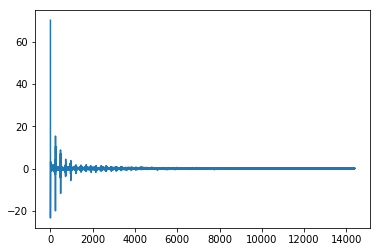

In [343]:
plt.plot(reg_2.coef_)

Text(0.5,1,'Using 41.67% of the original')

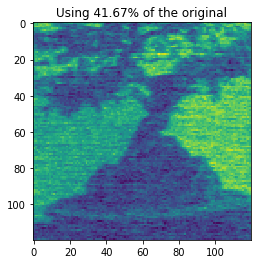

In [344]:
# Transform back to original basis
_rec_img = np.real( np.dot(rand_cD, reg_2.coef_).reshape(120,120) )
plt.imshow( _rec_img )
plt.title("Using {} of the original".format( str( round(((numPixels/(120*120))*100),2) ) + "%" ))

Text(0.5,1,'Original')

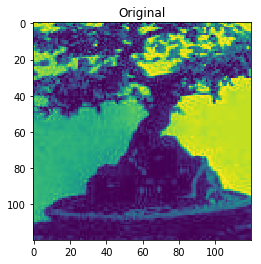

In [337]:
plt.imshow(_img1)
plt.title("Original")

Text(0.5,1,'| Actual - Reconstructed |')

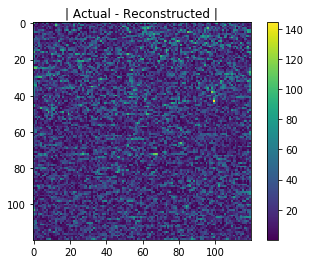

In [329]:
plt.imshow( abs(_img1 - _rec_img) )
plt.colorbar()
plt.title("| Actual - Reconstructed |")

The difference b/w the actual and reconstructed looks like noise probably because of the linear combinations of information when sampling/'sensing'

### References
arXiv:math/0503066v2 -- Stable Signal Recovery from Incomplete and Inaccurate Measurements <br>
https://nuit-blanche.blogspot.com/2013/09/videos-compressive-sensing-introduction.html <br>
http://www.vision.caltech.edu/Image_Datasets/Caltech101/ <-- DATA

Next would be to try with genetic data. Could use a reconstruction technique, such as lasso, to find a set of variants underlying some genetic signal. We would be assuming we are measuring in a space that is already where our sparse signal lives.  